In [1]:
%matplotlib inline

### Paremeter Estimation with Curve Fit

This is a five paremeter room RC model

dT = T(-dt/RC) + T_out(dt/RC) + E_lux(rho1*dt/C) + Occu(Q_int*dt/C) + Rads(Q_rad*dt/C) + q_vav(T_dat-T)*(rho2*dt/C) + dw

rho1: correlation between light intensity sensor and solar gain/electric lighting
rho2: correlation between the mass flow rate and volumetric flow rate
Simplified form:

$$ dT = -T*w_1 + T_out*w_1 + E_lux*w_2 + Occu * w_3 + Rads *w_4 - T*q_vav*w_5 + T_sup * q_vav * w_5 + w_6 $$


In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('data/EP_CO2_Infiltration.csv')
data = data.round({'IAT':2, 'OAT':2, 'OCCU':0, 'Lux':0, 'SupplyFlow':2, 'DAT':2})

In [3]:
def target(x, p1, p2, p3, p5, p6):
    return x[0] - x[0]*p1 + x[1]*p1 + x[2]*p2 + x[3]*p3 + x[4]*x[5]*p5 - x[0]*x[5]*p5 + p6

In [4]:
iterations = 10*24*12
cols = ['IAT', 'OAT', 'Lux', 'OCCU', 'DAT', 'SupplyFlow']
data = data[cols][:iterations]
np.random.seed(1234)
IAT_noise = np.random.normal(0,0.05,iterations)
OAT_noise = np.random.normal(0,0.05,iterations)
Lux_noise = np.random.normal(0,1,iterations)
DAT_noise = np.random.normal(0,0.1,iterations)
SAP_noise = np.random.normal(0,0.001,iterations)
print(len(IAT_noise))
data['IAT'] += IAT_noise
data['OAT'] += IAT_noise
data['Lux'] += IAT_noise
data['DAT'] += IAT_noise
data['SupplyFlow'] += IAT_noise

2880


In [5]:
data = data.as_matrix()
#print(data.shape)
#print(data)
inputs = data[:-1,].T
#print(inputs)
outputs = data[1:,0]
#print(outputs)

In [6]:
import scipy.optimize
import numpy as np
popt, pcov = scipy.optimize.curve_fit(target, inputs, outputs)
#popt = popt
print(popt)

[ 0.0018178   0.00013682 -0.00250866  0.10853727  0.00245721]


In [7]:
import lmfit
def thermModel(x0, x1, x2, x3, x5, x6, p1, p2, p3, p5, p6):
    #print(data)
    return x0 - x0*p1 + x1*p1 + x2*p2 + x3*p3 + x5*x6*p5 - x1*x6*p5 + p6
thermal = lmfit.Model(thermModel, independent_vars=['x0', 'x1','x2','x3','x5','x6'],params=['p1','p2','p3','p5','p6'])

In [8]:
params = lmfit.Parameters()
params.add('p1', value = 0.5, min=0., max=1.)
params.add('p2', value = 0.5, min=0., max=1.)
params.add('p3', value = 0.5, min=0., max=1.)
params.add('p5', value = 0.5, min=0., max=1.)
params.add('p6', value = 0.5, min=0., max=1.)

x0 = inputs[0].flatten()
x1 = inputs[1].flatten()
x2 = inputs[2].flatten()
x3 = inputs[3].flatten()
x5 = inputs[4].flatten()
x6 = inputs[5].flatten()

In [9]:
result = thermal.fit(outputs, x0=x0, x1=x1, x2=x2, x3=x3, x5=x5, x6=x6, params=params)
print(result.fit_report())
print(result.best_values)

[[Model]]
    Model(thermModel)
[[Fit Statistics]]
    # function evals   = 245
    # data points      = 2879
    # variables        = 5
    chi-square         = 13.653
    reduced chi-square = 0.005
[[Variables]]
    p1:   0.00354409 +/- 0.000294 (8.29%) (init= 0.5)
    p2:   0.00012948 +/- 4.78e-06 (3.69%) (init= 0.5)
    p3:   2.9577e-08 +/- 0.013884 (46945108.27%) (init= 0.5)
    p5:   0.08404172 +/- 0.002932 (3.49%) (init= 0.5)
    p6:   4.3021e-14 +/- 6.598244 (15337213723461660.00%) (init= 0.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(p1, p2)                    =  0.451 
    C(p2, p3)                    =  0.396 
    C(p3, p5)                    = -0.247 
    C(p1, p5)                    =  0.201 
    C(p2, p5)                    =  0.165 
    C(p1, p3)                    =  0.138 

{'p1': 0.003544094694095945, 'p2': 0.00012947775131899597, 'p3': 2.9576760429694815e-08, 'p5': 0.08404172793585718, 'p6': 4.3021142204224816e-14}


### Parameter Estimation with Recursive Constrained Dual Extended Kalman Filter

In [206]:
import sympy
w1, w2, w3, w4, w5, w6 = sympy.symbols('w1 w2 w3 w4 w5 w6')
x1, x2, x3, x4, x5, x6, u1, u2, u3, u4, u5, u6= sympy.symbols('x1 x2 x3 x4 x5 x6 u1 u2 u3 u4 u5 u6')
states = sympy.Matrix([[x1],
                      [x2],
                      [x3],
                      [x4],
                      [x5],
                      [x6]])
controls = sympy.Matrix([[u1],
                      [u2],
                      [u3],
                      [u4],
                      [u5],
                      [u6]])
params = sympy.Matrix([[w1],
                      [w2],
                      [w3],
                      [w4],
                      [w5],
                      [w6]])
fun = sympy.Matrix([[x1+u1*w1-x1*w1+u2*w2+u3*w3+u4*w4+u5*u6*w5-x1*u6*w5+w6],
                          [u1*w1-x1*w1],
                          [u2*w2],
                          [u3*w3],
                          [u4*w4],
                          [u5*u6*w5-x1*u6*w5]])
#Measurement Matrix, if virtual meters are available, more measurements can be added
C = np.zeros((6,6))
C[0,0] = 1
#print(fun.jacobian(params))

In [207]:
data = pd.read_csv('data/EP_CO2_Infiltration.csv')
data = data.round({'IAT':2, 'OAT':2, 'OCCU':0, 'Lux':0, 'SupplyFlow':2, 'DAT':2})

In [208]:
import library.DualEKF as DEKF
state_estimates = np.matrix([[data['IAT'][0]],
                            [0.0],
                            [0.0],
                            [0.0],
                            [0.0],
                            [0.0]])
param_estimates = np.matrix([[result.best_values['p1']],
                            [result.best_values['p2']],
                            [result.best_values['p3']],
                            [0.002],
                            [result.best_values['p5']],
                            [result.best_values['p6']]])
pw = np.array([0.03,0.0001,0.001,0.001,0.01,0.01])[np.newaxis]
Pw = pw.T * pw
px = np.array([0.1,0.01,0.01,0.01,0.01,0.01])[np.newaxis]
Px = px.T * px
tolerance = np.matrix([[0.0],
                       [0],
                       [0],
                       [0],
                       [0],
                      [0.0]])
h = sympy.Matrix([x2+x3+x4+x5+u1])
H = h.jacobian([x1,x2,x3,x4,x5])
print(H)
constr = np.ones(6)*1.0
temp_ekf = DEKF.DualExtendedKalmanFilter(fun, states, params, controls, C, state_estimates,
                                         param_estimates,forget=1.0,tolerance=tolerance,P_w=Pw, P_x = Px,
                                        constraint=constr, constrained=False)
#print(temp_ekf.FUN.jacobian(temp_ekf.W))
print(temp_ekf.C_w)

Matrix([[0, 1, 1, 1, 1]])
Matrix([[1.0*u1 - 1.0*x1, 1.0*u2, 1.0*u3, 1.0*u4, 1.0*u5*u6 - 1.0*u6*x1, 1.00000000000000], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0]])


In [209]:
import math
predicted = []
actual = []
measured = []
length = data.shape[0]
start = 1
step = 1
#iterations = (length-start)%step
iterations = 5000
np.random.seed(1234)
IAT_noise = np.random.normal(0,0.05,iterations+1)
OAT_noise = np.random.normal(0,0.05,iterations+1)
Lux_noise = np.random.normal(0,1,iterations+1)
DAT_noise = np.random.normal(0,0.1,iterations+1)
SAP_noise = np.random.normal(0,0.001,iterations+1)
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
noise_coef = 1.0
for i in range(start, iterations + start):
    #print(step*i)
    #generate control vector
    OAT = data['OAT'][step*i-1] + OAT_noise[i]*noise_coef
    Lux = data['Lux'][step*i-1] + Lux_noise[i]*noise_coef
    DAT = data["DAT"][step*i-1] + DAT_noise[i]*noise_coef
    SAP = data['SupplyFlow'][i-1] + SAP_noise[i]*noise_coef
    RAD = 0.0
    OCC = data["OCCU"][step*i-1]
    input_values = np.matrix([[OAT], 
                          [Lux], 
                          [OCC], 
                          [RAD],
                          [DAT],
                          [SAP]])

    #prediction
    temp_ekf.Predict(input_values)
    predicted.append(temp_ekf.X_values[0,0])
    #print(temp_ekf.W_values)
    #print(temp_ekf.W_initial)

    #update
    meas = data["IAT"][step*i] + IAT_noise[i]*noise_coef
    actual.append(data["IAT"][step*i])
    #print(meas-temp_ekf.X_values[0,0])
    measured.append(meas)
    temp_ekf.Update(np.matrix([[meas],[0],[0],[0],[0],[0]]))
    
    P1.append(temp_ekf.W_values[0,0])
    P2.append(temp_ekf.W_values[1,0])
    P3.append(temp_ekf.W_values[2,0])
    P4.append(temp_ekf.W_values[3,0])
    P5.append(temp_ekf.W_values[4,0])

    #print(temp_ekf.Pw)
    #print(temp_ekf.Kw)

In [210]:
#import scipy.optimize
#scipy.optimize.fmin_cobyla(temp_ekf.targetMin, temp_ekf.W_initial, [temp_ekf.constrLow, temp_ekf.constrHigh])

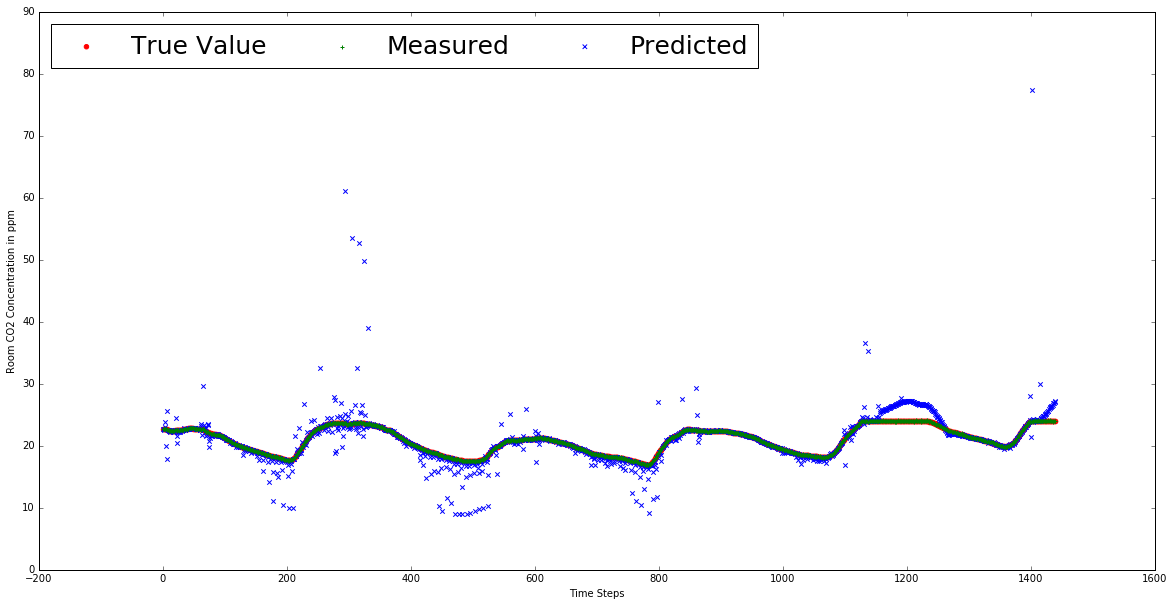

In [211]:
import matplotlib.pyplot as plt
#plotting first three days of prediction results
plot_len = (5*24*12)//step
#print(plot_len)
plot_start = 1000
if plot_start > iterations:
    plot_start = 0
if plot_len+plot_start > iterations:
    plot_len = iterations-plot_start
x = np.arange(plot_len)
#print(len(actual[start:200]))
plt.figure(figsize=(20,10))
tru = plt.scatter(x, actual[plot_start:plot_len+plot_start], color="r", marker="o")
pre = plt.scatter(x, predicted[plot_start:plot_len+plot_start], color="b", marker="x")
mea = plt.scatter(x, measured[plot_start:plot_len+plot_start], color="g", marker = "+")
plt.legend((tru,mea,pre),
           ("True Value","Measured","Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room CO2 Concentration in ppm")
plt.show()

In [212]:
print(temp_ekf.W_values)

[[  1.00000000e+00]
 [  1.29477751e-04]
 [  2.95767604e-08]
 [  2.00000000e-03]
 [  8.40417279e-02]
 [  4.30211422e-14]]


In [213]:
print(temp_ekf.X_values)

[[  2.08791686e+01]
 [  8.24506541e-02]
 [ -1.24689117e-02]
 [ -2.83022660e-02]
 [ -2.83022660e-02]
 [ -4.30174077e-02]]


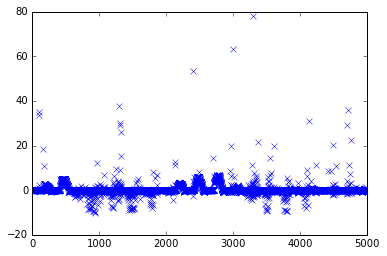

In [214]:
import operator
residues = list(map(operator.sub, predicted[start:], measured[start:]))
plt.plot(residues, 'x')
plt.show()

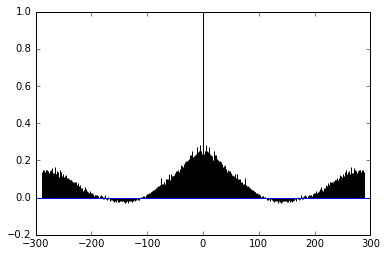

In [215]:
plt.acorr(residues, maxlags = 24*12)
plt.show()

In [216]:
normal_start = 15*24*12
if normal_start > iterations:
    normal_start = start
normal_end = 30*24*12
if normal_end > iterations:
    normal_end = iterations-1 
P1_normal = P1[normal_start:normal_end]
P2_normal = P2[normal_start:normal_end]
P3_normal = P3[normal_start:normal_end]
P4_normal = P4[normal_start:normal_end]
P5_normal = P5[normal_start:normal_end]

In [217]:
print('P1 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P1_normal),np.std(P1_normal)))
print('P2 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P2_normal),np.std(P2_normal)))
print('P3 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P3_normal),np.std(P3_normal)))
print('P4 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P4_normal),np.std(P4_normal)))
print('P5 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P5_normal),np.std(P5_normal)))

P1 ideal value is 0, estimated average is 0.22029766490535221 and std is 0.36513538528226785 
P2 ideal value is 0, estimated average is 0.0026028024635176123 and std is 0.014820644201696103 
P3 ideal value is 0, estimated average is 0.0022332763872844603 and std is 0.011050378737940684 
P4 ideal value is 0, estimated average is 0.003913379894154527 and std is 0.011278919477664347 
P5 ideal value is 0, estimated average is 0.08813172884189432 and std is 0.03949940026068579 


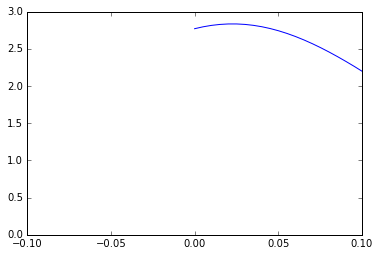

In [218]:
from scipy.stats import gaussian_kde
P1_kde = gaussian_kde(P1_normal)
P1_xs = np.linspace(min(P1_normal),max(P1_normal),200)
plt.plot(P1_xs,P1_kde(P1_xs))
plt.xlim([-0.1,0.1])
plt.show()

(-0.1, 1)

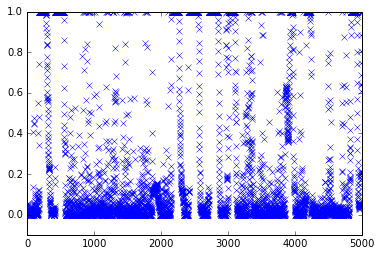

In [219]:
plt.plot(P1,'x')
plt.ylim([-0.1,1])

### Parameter Estimation with Parameter EKF (weight estimation)

In [10]:
import numpy as np
import sympy
import library.EKF as EKF
import pandas as pd

In [11]:
p1, p2, p3, p4, p5, p6 = sympy.symbols('p1 p2 p3 p4 p5 p6')
x1, x2, x3, x4, x5, x6, x7 = sympy.symbols('x1 x2 x3 x4 x5 x6 x7')
states = sympy.Matrix([[x1],
                      [x2],
                      [x3],
                      [x4],
                      [x5],
                      [x6],
                      [x7]])
params = sympy.Matrix([[p1],
                      [p2],
                      [p3],
                      [p4],
                      [p5],
                      [p6]])
function = sympy.Matrix([x1+x2*p1-x1*p1+x3*p2+x4*p3+x5*p4+x6*x7*p5-x1*x7*p5+p6])
param_estimates = np.matrix([[result.best_values['p1']],
                            [result.best_values['p2']],
                            [result.best_values['p3']],
                            [0.002],
                            [result.best_values['p5']],
                            [result.best_values['p6']]])
timeCoef = 1
param_estimates *= timeCoef
P = np.eye(6)*0.01
Re = np.eye(1)*0.5
print(param_estimates)
pekf = EKF.ExtendedKalmanFilterParameter(function, params, states, P, param_estimates, 
                                         Re=Re, forget=1, constrained=True)

[[  3.54409469e-03]
 [  1.29477751e-04]
 [  2.95767604e-08]
 [  2.00000000e-03]
 [  8.40417279e-02]
 [  4.30211422e-14]]


In [12]:
data = pd.read_csv('data/EP_CO2.csv')
length = data.shape[0]
step = 1
#iterations = length
iterations = 8000
np.random.seed(1234)
IAT_noise = np.random.normal(0,0.05,iterations)
OAT_noise = np.random.normal(0,0.05,iterations)
Lux_noise = np.random.normal(0,1,iterations)
DAT_noise = np.random.normal(0,0.1,iterations)
SAP_noise = np.random.normal(0,0.001,iterations)
prediction = []
measurement = []
i = 1
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
noise_coef = 1.0

In [13]:
for i in range(1, iterations):
    IAT = data['IAT'][step*i-1] + IAT_noise[i]*noise_coef
    OAT = data['OAT'][step*i-1] + OAT_noise[i]*noise_coef
    Lux = data['Lux'][step*i-1] + Lux_noise[i]*noise_coef
    DAT = data["DAT"][step*i-1] + DAT_noise[i]*noise_coef
    SAP = data['SupplyFlow'][i-1] + SAP_noise[i]*noise_coef
    #SAP = math.sqrt(data['SAP'][i-1])
    RAD = 0
    OCC = data["OCCU"][i-1]
    controls = np.matrix([[IAT],
                          [OAT],
                          [Lux],
                          [OCC],
                          [RAD],
                          [DAT],
                          [SAP]])
    pekf.Predict(controls)
    prediction.append(pekf.prediction[0,0])
    #print(pekf.Cw_values)
    measure = np.matrix([[IAT]])
    measurement.append(IAT)
    pekf.Update(measure)
    P1.append(pekf.W_values[0,0])
    P2.append(pekf.W_values[1,0])
    P3.append(pekf.W_values[2,0])
    P4.append(pekf.W_values[3,0])
    P5.append(pekf.W_values[4,0])
    P6.append(pekf.W_values[5,0])

In [14]:
print(pekf.W_values)

[[  1.39056624e-04]
 [  1.29477751e-04]
 [ -4.96706652e-21]
 [  1.98197444e-03]
 [  8.38380590e-02]
 [ -4.96164553e-21]]


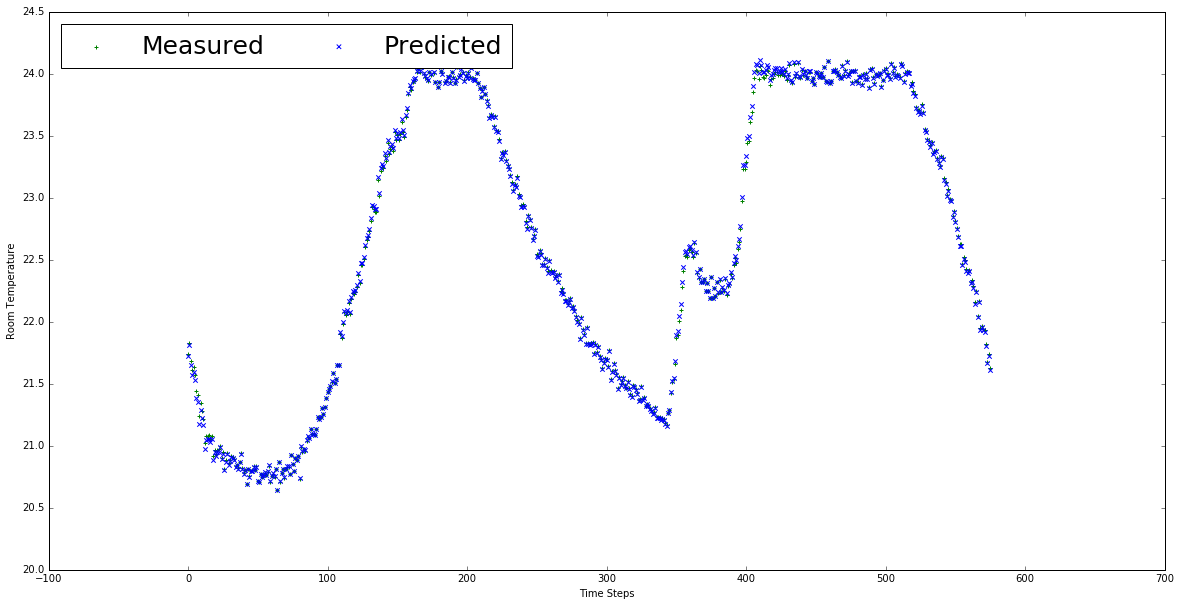

In [15]:
import matplotlib.pyplot as plt
start = 15*24*12
plot_len = (2*24*12)
if start < iterations:
    start = 0
if iterations -1 < plot_len:
    plot_len = iterations - 1
x = np.arange(plot_len)
plt.figure(figsize=(20,10))
mea = plt.scatter(x, measurement[start:plot_len+start], color="g", marker = "+")
pre = plt.scatter(x, prediction[start:plot_len+start], color="b", marker="x")
plt.legend((mea,pre),
           ("Measured", "Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room Temperature")
plt.show()

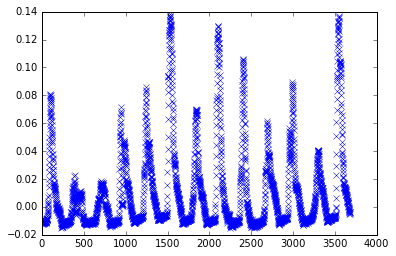

In [16]:
normal_start = 15*24*12
normal_end = 30*24*12
import operator
residues = list(map(operator.sub, prediction[normal_start:], measurement[normal_start:]))
plt.plot(residues, 'x')
plt.show()

In [17]:
P1_normal = P1[normal_start:normal_end]
P2_normal = P2[normal_start:normal_end]
P3_normal = P3[normal_start:normal_end]
P4_normal = P4[normal_start:normal_end]
P5_normal = P5[normal_start:normal_end]
P6_normal = P6[normal_start:normal_end]

In [18]:
print('P1 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P1_normal),np.std(P1_normal)))
print('P2 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P2_normal),np.std(P2_normal)))
print('P3 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P3_normal),np.std(P3_normal)))
print('P4 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P4_normal),np.std(P4_normal)))
print('P5 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P5_normal),np.std(P5_normal)))
print('P6 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P6_normal),np.std(P6_normal)))
print(param_estimates)

P1 ideal value is 0, estimated average is 0.00013037010175525037 and std is 1.528925600567237e-05 
P2 ideal value is 0, estimated average is 0.0001294577009433597 and std is 1.5901987483445215e-07 
P3 ideal value is 0, estimated average is 4.088523841677152e-05 and std is 8.43313575954968e-05 
P4 ideal value is 0, estimated average is 0.0019611347973426457 and std is 5.8603847739584505e-05 
P5 ideal value is 0, estimated average is 0.08359972722994412 and std is 0.0003380672055149498 
P6 ideal value is 0, estimated average is 8.890168543504625e-05 and std is 0.00010808434435163642 
[[  3.54409469e-03]
 [  1.29477751e-04]
 [  2.95767604e-08]
 [  2.00000000e-03]
 [  8.40417279e-02]
 [  4.30211422e-14]]


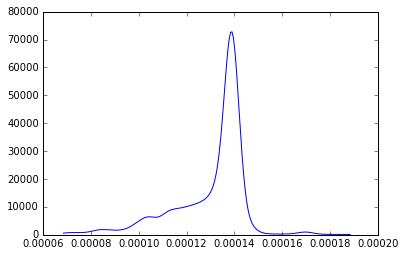

In [19]:
from scipy.stats import gaussian_kde
P1_kde = gaussian_kde(P1_normal)
P1_xs = np.linspace(min(P1_normal),max(P1_normal),200)
plt.plot(P1_xs,P1_kde(P1_xs))
plt.show()

## Real Measurement

In [32]:
data = pd.read_csv('data/CB5208_Dataset.csv')

In [33]:
iterations = 7*24*12
#cols = ['IAT', 'OAT', 'Lux', 'OCC', 'DAT', 'SupplyFlow']
#data = data.round({'IAT':2, 'OAT':2, 'OCCU':0, 'Lux':0, 'SupplyFlow':2, 'DAT':2})
cols = ['IAT', 'OAT', 'Lux', 'OCC', 'DAT', 'SAP']
data = data.round({'IAT':2, 'OAT':2, 'OCCU':0, 'Lux':0, 'SAP':2, 'DAT':2})
data = data[cols]
data = data[cols][:iterations]
np.random.seed(1234)
IAT_noise = np.random.normal(0,0.05,iterations)
OAT_noise = np.random.normal(0,0.05,iterations)
Lux_noise = np.random.normal(0,1,iterations)
DAT_noise = np.random.normal(0,0.1,iterations)
SAP_noise = np.random.normal(0,0.001,iterations)
noise_scale = 0.0
#print(len(IAT_noise))
data['IAT'] += IAT_noise*noise_scale
data['OAT'] += OAT_noise*noise_scale
data['Lux'] += Lux_noise*noise_scale
data['DAT'] += DAT_noise*noise_scale
#data['SupplyFlow'] += SAP_noise*noise_scale
data['SAP'] = data['SAP'].apply(np.sqrt)
data['SAP'] += SAP_noise*noise_scale
data = data.as_matrix()
#print(data.shape)
#print(data)
inputs = data[:-1,].T
#print(inputs)
outputs = data[1:,0]
#print(outputs)

#popt, pcov = scipy.optimize.curve_fit(target, inputs, outputs)
#print(popt**2)
params = lmfit.Parameters()
params.add('p1', value = 0.5, min=0., max=1.)
params.add('p2', value = 0.5, min=0., max=1.)
params.add('p3', value = 0.5, min=0., max=1.)
params.add('p5', value = 0.5, min=0., max=1.)
params.add('p6', value = 0.5, min=0., max=1.)

x0 = inputs[0].flatten()
x1 = inputs[1].flatten()
x2 = inputs[2].flatten()
x3 = inputs[3].flatten()
x5 = inputs[4].flatten()
x6 = inputs[5].flatten()
#out = lmfit.minimize(residual, params, args=(x0,x1,x2,x3,x5,x6,outputs))
#print(out)

thermal = lmfit.Model(thermModel, independent_vars=['x0', 'x1','x2','x3','x5','x6'],params=['p1','p2','p3','p5','p6'])
result = thermal.fit(outputs, x0=x0, x1=x1, x2=x2, x3=x3, x5=x5, x6=x6, params=params)
print(result.fit_report())
print(result.best_values)

[[Model]]
    Model(thermModel)
[[Fit Statistics]]
    # function evals   = 123
    # data points      = 2015
    # variables        = 5
    chi-square         = 24.986
    reduced chi-square = 0.012
[[Variables]]
    p1:   0.00558524 +/- 0.000500 (8.95%) (init= 0.5)
    p2:   0.00016157 +/- 1.47e-05 (9.08%) (init= 0.5)
    p3:   0.01954008 +/- 0.015317 (78.39%) (init= 0.5)
    p5:   1.9531e-11 +/- 6.42e-05 (328859496.03%) (init= 0.5)
    p6:   0.03255963 +/- 0.005035 (15.47%) (init= 0.5)
[[Correlations]] (unreported correlations are <  0.100)
    C(p1, p6)                    =  0.728 
    C(p1, p5)                    = -0.464 
    C(p2, p6)                    = -0.412 
    C(p2, p3)                    = -0.292 
    C(p1, p2)                    = -0.223 

{'p1': 0.0055852491713038743, 'p2': 0.00016157279955131276, 'p3': 0.019540086816087043, 'p5': 1.9531209982659448e-11, 'p6': 0.032559634630776269}


In [34]:
import math
data = pd.read_csv('data/CB5208_Dataset.csv')
param_estimates = np.matrix([[result.best_values['p1']],
                            [result.best_values['p2']],
                            [result.best_values['p3']],
                            [0.002],
                            [result.best_values['p5']],
                            [result.best_values['p6']]])
p1, p2, p3, p4, p5, p6 = sympy.symbols('p1 p2 p3 p4 p5 p6')
x1, x2, x3, x4, x5, x6, x7 = sympy.symbols('x1 x2 x3 x4 x5 x6 x7')
states = sympy.Matrix([[x1],
                      [x2],
                      [x3],
                      [x4],
                      [x5],
                      [x6],
                      [x7]])
params = sympy.Matrix([[p1],
                      [p2],
                      [p3],
                      [p4],
                      [p5],
                      [p6]])
function = sympy.Matrix([x1+x2*p1-x1*p1+x3*p2+x4*p3+x5*p4+x6*x7*p5-x1*x7*p5+p6])
pekf = EKF.ExtendedKalmanFilterParameter(function, params, states, P, param_estimates, 
                                         Re=Re, forget=1, constrained=True)
print(param_estimates)

[[  5.58524917e-03]
 [  1.61572800e-04]
 [  1.95400868e-02]
 [  2.00000000e-03]
 [  1.95312100e-11]
 [  3.25596346e-02]]


In [37]:
length = data.shape[0]
step = 1
iterations = length
#iterations = 5000
prediction = []
measurement = []
P1 = []
P2 = []
P3 = []
P4 = []
P5 = []
P6 = []
noise_coef = 0.0

In [38]:
for i in range(1, iterations):
    IAT = data['IAT'][step*i-1]
    OAT = data['OAT'][step*i-1]
    Lux = data['Lux'][step*i-1]
    DAT = data["DAT"][step*i-1]
    #SAP = data['SupplyFlow'][i-1] + SAP_noise[i]*noise_coef
    SAP = math.sqrt(data['SAP'][i-1])
    RAD = 0
    OCC = data["OCC"][i-1]
    controls = np.matrix([[IAT],
                          [OAT],
                          [Lux],
                          [OCC],
                          [RAD],
                          [DAT],
                          [SAP]])
    pekf.Predict(controls)
    prediction.append(pekf.prediction[0,0])
    #print(pekf.Cw_values)
    measure = np.matrix([[IAT]])
    measurement.append(IAT)
    pekf.Update(measure)
    #print(pekf.initial_estimates)
    P1.append(pekf.W_values[0,0])
    P2.append(pekf.W_values[1,0])
    P3.append(pekf.W_values[2,0])
    P4.append(pekf.W_values[3,0])
    P5.append(pekf.W_values[4,0])
    P6.append(pekf.W_values[5,0])

In [39]:
print(len(measurement), len(prediction), iterations)

5436 5436 5437


0 864


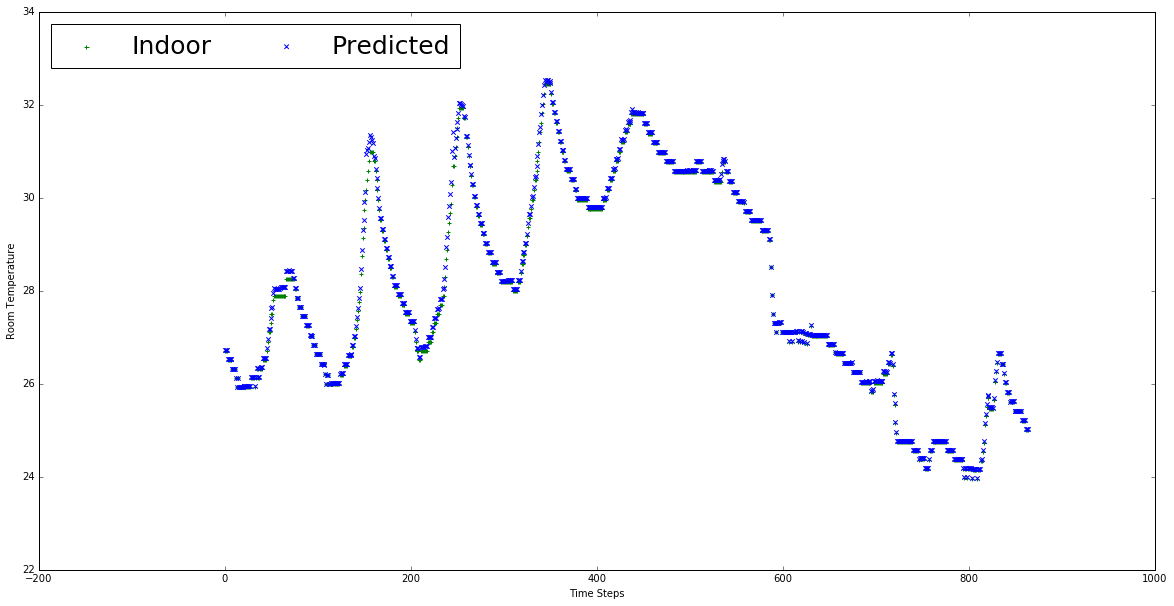

In [40]:
import matplotlib.pyplot as plt
#start = 15*24*12
start = 7*24*12
plot_len = (3*24*12)
if start < iterations:
    start = 0
if iterations -1 < plot_len:
    plot_len = iterations - 1
print(start, plot_len)
x = np.arange(plot_len)
plt.figure(figsize=(20,10))
mea = plt.scatter(x, measurement[start:plot_len+start], color="g", marker = "+")
pre = plt.scatter(x, prediction[start:plot_len+start], color="b", marker="x")
plt.legend((mea,pre),
           ("Indoor", "Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room Temperature")
plt.show()

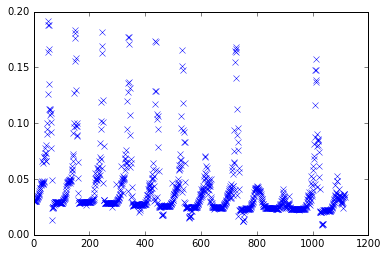

In [41]:
normal_start = 15*24*12
normal_end = 30*24*12
import operator
residues = list(map(operator.sub, prediction[normal_start:], measurement[normal_start:]))
plt.plot(residues, 'x')
plt.show()

In [42]:
P1_normal = P1[normal_start:normal_end]
P2_normal = P2[normal_start:normal_end]
P3_normal = P3[normal_start:normal_end]
P4_normal = P4[normal_start:normal_end]
P5_normal = P5[normal_start:normal_end]
P6_normal = P6[normal_start:normal_end]

In [43]:
print('P1 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P1_normal),np.std(P1_normal)))
print('P2 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P2_normal),np.std(P2_normal)))
print('P3 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P3_normal),np.std(P3_normal)))
print('P4 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P4_normal),np.std(P4_normal)))
print('P5 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P5_normal),np.std(P5_normal)))
print('P6 ideal value is 0, estimated average is {0} and std is {1} '.format(np.mean(P6_normal),np.std(P6_normal)))
print(param_estimates)

P1 ideal value is 0, estimated average is 0.00026434853381335796 and std is 3.309067355743175e-05 
P2 ideal value is 0, estimated average is 0.0001377428216959704 and std is 7.436372600653097e-06 
P3 ideal value is 0, estimated average is 0.014892266194342205 and std is 0.0023683875573788336 
P4 ideal value is 0, estimated average is 0.003393262741177745 and std is 4.336808689942018e-19 
P5 ideal value is 0, estimated average is 0.0004953114431544088 and std is 0.0001728238872950152 
P6 ideal value is 0, estimated average is 0.027713969834824423 and std is 0.0013238660900487355 
[[  5.58524917e-03]
 [  1.61572800e-04]
 [  1.95400868e-02]
 [  2.00000000e-03]
 [  1.95312100e-11]
 [  3.25596346e-02]]


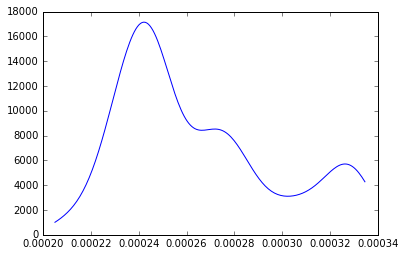

In [44]:
from scipy.stats import gaussian_kde
P1_kde = gaussian_kde(P1_normal)
P1_xs = np.linspace(min(P1_normal),max(P1_normal),200)
plt.plot(P1_xs,P1_kde(P1_xs))
plt.show()

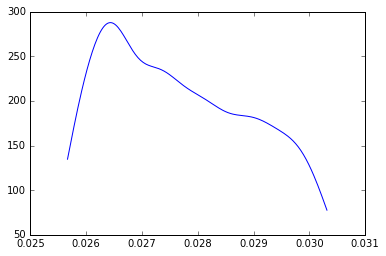

In [45]:
P6_kde = gaussian_kde(P6_normal)
P6_xs = np.linspace(min(P6_normal),max(P6_normal),200)
plt.plot(P6_xs,P6_kde(P6_xs))
plt.show()

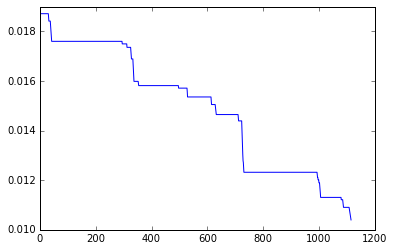

In [47]:
plt.plot(P3_normal)
plt.show()